In [1]:
import numpy as np
import matplotlib.pyplot as plt
# for this assignment we are using this only for ploting the MSE in each tuning iteration

In [2]:
np.random.seed(100)

In [3]:
#Object Oriented approach of the neural network model has been taken here
#we are assuming here that weights,bias,activation function can be given by the user as function parameter
# if these paremeters are not passed to the class , each layer will be likely different
# w.r.t to the bias and weights from the other one
# To make the the whole program generic , we have assumed that there can be 
# more than one activation function to experiment with, so every time we create an object 
# of this class we specify the activation type

In [4]:
class Layer:
    """
    Represents a layer (hidden or output) in our neural network.
    """

    def __init__(self, n_input, n_neurons, activation=None, weights=None, bias=None):
        """
        :param int n_input: The input size (coming from the input layer or a previous hidden layer)
        :param int n_neurons: The number of neurons in this layer.
        :param str activation: The activation function to use (if any).
        :param weights: The layer's weights.
        :param bias: The layer's bias.
        """
        
        # if bias and weights are not passed to the constructor set them randomly
        self.weights = weights if weights is not None else np.random.rand(n_input, n_neurons)
        self.activation = activation
        self.bias = bias if bias is not None else np.random.rand(n_neurons)
        self.last_activation = None # incase we need different activation functions in future
        self.error = None
        self.delta = None

    def activate(self, x):
        """
        Calculates the dot product of this layer.
        :param x: The input.
        :return: The result.
        """

        r = np.dot(x, self.weights) + self.bias
        self.last_activation = self._apply_activation(r)
        return self.last_activation

    def _apply_activation(self, r):
        """
        Applies the chosen activation function (if any).
        :param r: The normal value.
        :return: The "activated" value.
        """

        # sigmoid
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))

        return r

    def apply_activation_derivative(self, r):
        """
        Applies the derivative of the activation function (if any).
        :param r: The normal value.
        :return: The "derived" value.
        """

        # We use 'r' directly here because its already activated, the only values that
        # are used in this function are the last activations that were saved.

        if self.activation == 'sigmoid':
            return r * (1 - r)

        return r


In [5]:
# Object Oriented implementation of the actual network.
# here the input to the network acts as the input layer
# every time we add a hidden layer( remember: the last hidden layer is actuall the output layer)
# by calling the add_layer() function
# The add_layer() calls' parameters should be in zig-zag format


In [6]:
class NeuralNetwork:
    """
    Represents a neural network.
    """

    def __init__(self):
        self._layers = []

    def add_layer(self, layer):
        """
        Adds a layer to the neural network.
        :param Layer layer: The layer to add.
        """

        self._layers.append(layer)

    def feed_forward(self, X):
        """
        Feed forward the input through the layers.
        :param X: The input values.
        :return: The result.
        """

        for layer in self._layers:
            X = layer.activate(X)

        return X

    def predict(self, X):
        """
        Predicts a class (or classes).
        :param X: The input values.
        :return: The predictions.
        """

        ff = self.feed_forward(X)

        # If One row output, simply return the value
        if ff.ndim == 1:
            return np.argmax(ff)

        # If Multiple rows, return the index having maximum value 
        return np.argmax(ff, axis=1)

    def backpropagation(self, X, y, learning_rate):
        """
        Performs the backward propagation algorithm and updates the layers weights.
        :param X: The input values.
        :param y: The target values.
        :param float learning_rate: The learning rate (between 0 and 1).
        """

        # Feed forward for the output
        output = self.feed_forward(X)

        # Loop over the layers backward
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i]

            # If this is the output layer
            if layer == self._layers[-1]:
                layer.error = y - output
                # The output = layer.last_activation in this case
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else:
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)

        # Update the weights
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # The input is either the previous layers output or X itself (for the first hidden layer)
            # the input shoul be atleast two
            input_to_use = np.atleast_2d(X if i == 0 else self._layers[i - 1].last_activation)
            layer.weights += layer.delta * input_to_use.T * learning_rate

    def train(self, X, y, learning_rate, max_epochs):
        """
        Trains the neural network using backpropagation.
        :param X: The input values.
        :param y: The target values.
        :param float learning_rate: The learning rate (between 0 and 1).
        :param int max_epochs: The maximum number of epochs (cycles).
        :return: The list of calculated MSE errors.
        """
        # stores the MSE values in each iteration ( useful for ploting purpose)
        mses = []

        for i in range(max_epochs):
            for j in range(len(X)):
                self.backpropagation(X[j], y[j], learning_rate)
            if i % 1000 == 0:
                mse = np.mean(np.square(y - self.feed_forward(X)))
                mses.append(mse)
                print('Epoch: #%s, MSE: %f' % (i, float(mse)))

        return mses
    
#     @staticmethod
#     def accuracy(y_pred, y_true):
#         """
#         Calculates the accuracy between the predicted labels and true labels.
#         :param y_pred: The predicted labels.
#         :param y_true: The true labels.
#         :return: The calculated accuracy.
#         """

#         return (y_pred == y_true).mean()


In [7]:
# For this assignment we have to find the optimal learning rate for the whole model for which MSE becomes 0 ( let say)
# on earlier iteration

# We are calling this function with learning rate = learning  rate  + 0.1

In [8]:

def tune(lr):
    nn = NeuralNetwork()
    nn.add_layer(Layer(3, 5, 'sigmoid'))
    nn.add_layer(Layer(5, 3, 'sigmoid'))
    nn.add_layer(Layer(3, 2, 'sigmoid'))

    # Define dataset
    X = np.array([[0, 0,0],[0,0,1], [0, 1,0], [0,1, 1], [1,0,0],[1, 1,1]])
    y = np.array([[0], [0], [0],[0],[0],[1]])

    # Train the neural network
    errors = nn.train(X, y,lr, 10000)
#     print('Accuracy: %.2f%%' % (nn.accuracy(nn.predict(X), y.flatten()) * 100))

    # Plot changes in mse
    plt.plot(errors)
    plt.title('Changes in MSE')
    plt.xlabel('Epoch (every 1000th)')
    plt.ylabel('MSE')
    plt.show()

#     print(nn.predict([[1,1,1], [1,1,1], [1,0,1]]))
    
    
    


In [9]:
# Calling the tune function with increasing lr value.
# we have to compare with plot carefully. for some iteration the output can be totally different 
# especially for the higher lr values ( over fitting)
# for extremely lower lr values we may require a large number of max_iteration value.
# we are starting the tuning with initial lr value 0.2 and continue upto 0.9

Training set : Bipolar AND

Testing the network with learning rate  0.2
Epoch: #0, MSE: 0.587965
Epoch: #1000, MSE: 0.135627
Epoch: #2000, MSE: 0.058733
Epoch: #3000, MSE: 0.002685
Epoch: #4000, MSE: 0.001196
Epoch: #5000, MSE: 0.000753
Epoch: #6000, MSE: 0.000546
Epoch: #7000, MSE: 0.000426
Epoch: #8000, MSE: 0.000349
Epoch: #9000, MSE: 0.000295


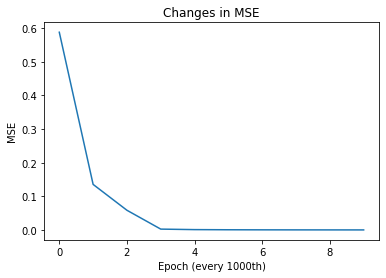


Testing the network with learning rate  0.30000000000000004
Epoch: #0, MSE: 0.563273
Epoch: #1000, MSE: 0.138509
Epoch: #2000, MSE: 0.003410
Epoch: #3000, MSE: 0.000838
Epoch: #4000, MSE: 0.000459
Epoch: #5000, MSE: 0.000313
Epoch: #6000, MSE: 0.000236
Epoch: #7000, MSE: 0.000189
Epoch: #8000, MSE: 0.000158
Epoch: #9000, MSE: 0.000135


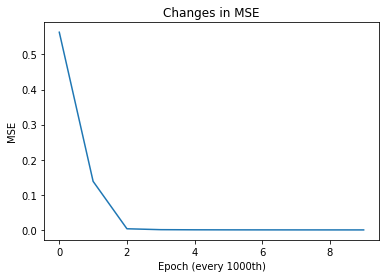


Testing the network with learning rate  0.4
Epoch: #0, MSE: 0.451128
Epoch: #1000, MSE: 0.020802
Epoch: #2000, MSE: 0.001178
Epoch: #3000, MSE: 0.000545
Epoch: #4000, MSE: 0.000348
Epoch: #5000, MSE: 0.000254
Epoch: #6000, MSE: 0.000199
Epoch: #7000, MSE: 0.000164
Epoch: #8000, MSE: 0.000139
Epoch: #9000, MSE: 0.000120


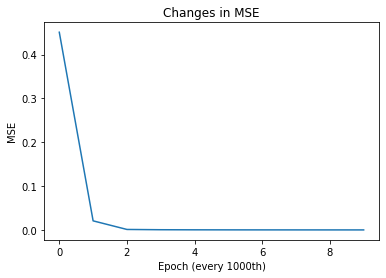


Testing the network with learning rate  0.5
Epoch: #0, MSE: 0.506018
Epoch: #1000, MSE: 0.002822
Epoch: #2000, MSE: 0.000503
Epoch: #3000, MSE: 0.000258
Epoch: #4000, MSE: 0.000170
Epoch: #5000, MSE: 0.000125
Epoch: #6000, MSE: 0.000099
Epoch: #7000, MSE: 0.000081
Epoch: #8000, MSE: 0.000069
Epoch: #9000, MSE: 0.000060


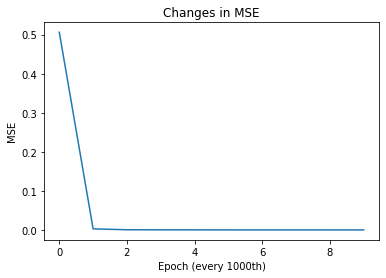


Testing the network with learning rate  0.6
Epoch: #0, MSE: 0.584105
Epoch: #1000, MSE: 0.127817
Epoch: #2000, MSE: 0.000915
Epoch: #3000, MSE: 0.000388
Epoch: #4000, MSE: 0.000243
Epoch: #5000, MSE: 0.000177
Epoch: #6000, MSE: 0.000139
Epoch: #7000, MSE: 0.000114
Epoch: #8000, MSE: 0.000096
Epoch: #9000, MSE: 0.000084


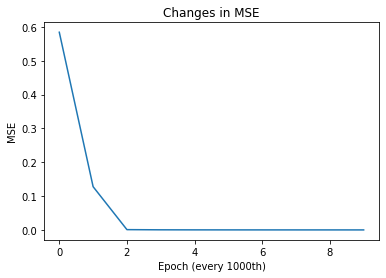


Testing the network with learning rate  0.7
Epoch: #0, MSE: 0.531564
Epoch: #1000, MSE: 0.002051
Epoch: #2000, MSE: 0.000380
Epoch: #3000, MSE: 0.000201
Epoch: #4000, MSE: 0.000136
Epoch: #5000, MSE: 0.000102
Epoch: #6000, MSE: 0.000081
Epoch: #7000, MSE: 0.000067
Epoch: #8000, MSE: 0.000058
Epoch: #9000, MSE: 0.000050


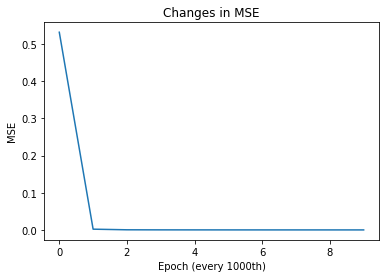


Testing the network with learning rate  0.7999999999999999
Epoch: #0, MSE: 0.282077
Epoch: #1000, MSE: 0.000853
Epoch: #2000, MSE: 0.000253
Epoch: #3000, MSE: 0.000144
Epoch: #4000, MSE: 0.000100
Epoch: #5000, MSE: 0.000076
Epoch: #6000, MSE: 0.000062
Epoch: #7000, MSE: 0.000052
Epoch: #8000, MSE: 0.000044
Epoch: #9000, MSE: 0.000039


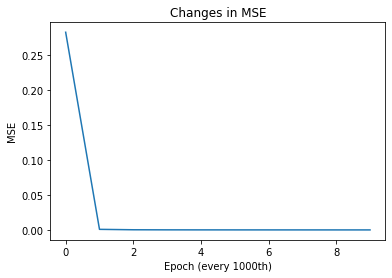


Testing the network with learning rate  0.8999999999999999
Epoch: #0, MSE: 0.542786
Epoch: #1000, MSE: 0.026983
Epoch: #2000, MSE: 0.025789
Epoch: #3000, MSE: 0.025503
Epoch: #4000, MSE: 0.025381
Epoch: #5000, MSE: 0.025315
Epoch: #6000, MSE: 0.025276
Epoch: #7000, MSE: 0.025249
Epoch: #8000, MSE: 0.025231
Epoch: #9000, MSE: 0.025217


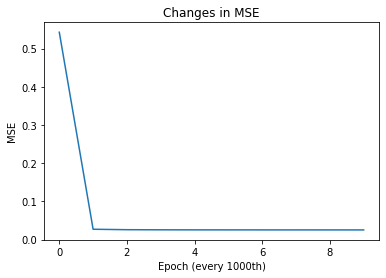

In [10]:
if __name__ == '__main__':
    print("Training set : Bipolar AND")
    lr = 0.2
    for i in range(2,10):
        print()
        print("Testing the network with learning rate ",lr)
        tune(lr)
        lr += 0.1
    

In [11]:
# From the obove output it is clear that from 0.5 - 0.9 the model converge faster than the lower lr values.